# Advanced Binary Image Segmentation for the Geo- and Eco-sciences, using Deep Learning

## Case Study: Detecting Intertidal Reefs

#### Daniel Buscombe, MARDA Science

![](https://mardascience.com/wp-content/uploads/2019/06/cropped-MardaScience_logo-5.png)

Before you do anything, go to `File > Save copy in Drive` so you can keep and work on your own copy

## Lesson 3: Getting ready to train a oyster reef masker (binary segmentation of intertidal shellfish reefs) with the "OysterNet" data set

This jupyter notebook running on Google Colab is part of the "Advanced Binary Image Segmentation for the Geo- and Eco-sciences, using Deep Learning" course. The main course website can be accessed [here](https://mardascience.gitlab.io/binary_image_segmentation_for_geosciences/#/)

In the previous lesson we made functions to read and pair image and label tiles from this data. In this lesson, we will start by repeating that process without the visualization steps

Then we will construct, train and evaluate the model. In the [oysterNet paper](https://zslpublications.onlinelibrary.wiley.com/doi/full/10.1002/rse2.134), the authors used a bigger, more sophisticated model for `instance segmentation`, that is, semantic segmentation that is aware of all the different `instances` of the class (i.e. each individual piece of reef). The model they use is called `Mask RCNN`, the implementation of which is [here](https://github.com/matterport/Mask_RCNN). That is a large and very complicated model that is hard to experiment with. The research behind the [oysterNet paper](https://zslpublications.onlinelibrary.wiley.com/doi/full/10.1002/rse2.134) is state-of-the-art.

Here, we use a simpler model with fewer parameters (namely, a residual UNet) and acheive acceptable results for a semantic segmentation (predicting the masks of where the reefs are, rather than by individual instances). The UNet is the same we used in a [previous set of tutorials](https://mardascience.gitlab.io/deep_learning_landscape_classification/#/) and is relatively simple to adapt and play with to demonstrate a few principles.

Actually, in this tutorial we'll start with a basic implementation and get really bad results (!). This is designed to introduce you to the complicated workflow, but at the same time demonstrating a principle: use an appropriate loss function to train your model - one that isn't sensitive to class imbalance. We talk about what that means as we go

This is designed to demonstrate a problem-solving strategy, and also a principle that often applies to natural imagery:

> It's not just the model you choose, it's how you train it that counts

### Import libraries

In [0]:
import os #for accessing operating system utilities
from glob import glob #for finding files that match a certain string pattern
import matplotlib.pyplot as plt #for plotting
import numpy as np #for numerical operations
import random, string #for creating random strings
import tensorflow as tf #tensorflow
import json # for reading lable annotations in json format
import requests #for downloading files 
from PIL import Image, ImageFilter #for reading and filtering imagery
import skimage.draw #for making masks (raster label images) from label annotations
from skimage.transform import resize #for resizing imagery
from psutil import virtual_memory #for interrogating our filesystem and RAM specifications
from imageio import imwrite

### Prepare the data

#### Download the JSON annotations and imagery

If you followed the previous lesson, you'll see that we downloaded the dataset consisting of three large (spatially extensive) orthomosaics, split that data into 555 tiles and labels, and visualize those data

Because this lesson assumes you are running this notebook on Google Colab, we'll have to download and split the data again before training a model. This time we'll do it without the commentary. If you need a recap, see the previous lesson

In [0]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    """
    response = filename for input
    destination = filename for output
    """    
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [0]:
## if you are doing this for the second time, you'll want to delete the files first
# !rm -rf 1kx1k_dataset
# !rm 1kx1k_dataset.zip

In [0]:
file_id = '1gJq3J8CpXZqLGgUeOU7rXRGEq9glOMmI'
destination = '1kx1k_dataset.zip'
download_file_from_google_drive(file_id, destination)

In [0]:
!unzip 1kx1k_dataset.zip > tmp.txt

In [0]:
data_dir = "1kx1k_dataset/test"
test_annotations = json.load(open(os.path.join(data_dir, "via_region_data.json")))
test_annotations = list(test_annotations.values()) 

In [0]:
data_dir = "1kx1k_dataset/train"
train_annotations = json.load(open(os.path.join(data_dir, "via_region_data.json")))
train_annotations = list(train_annotations.values()) 

In [0]:
data_dir = "1kx1k_dataset/val"
val_annotations = json.load(open(os.path.join(data_dir, "via_region_data.json")))
val_annotations = list(val_annotations.values()) 

In [0]:
print("# test files: %i" % (len(test_annotations)))
print("# train files: %i" % (len(train_annotations)))
print("# validation files: %i" % (len(val_annotations)))

# test files: 163
# train files: 527
# validation files: 130


#### Visualize

In [0]:
a = test_annotations[50]

im = Image.open(os.path.join(data_dir, a['filename']))

Text(0.5, 1.0, 'Filtered')

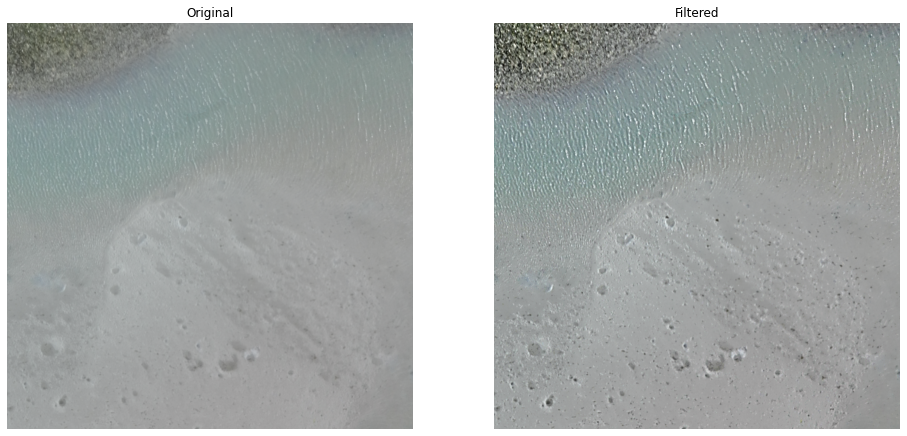

In [0]:
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(np.array(im))
plt.axis('off')
plt.title('Original')

plt.subplot(122)
im = im.filter(ImageFilter.UnsharpMask(radius=5, percent=200, threshold=3))
plt.imshow(np.array(im))
plt.axis('off')
plt.title('Filtered')

#### Augment

Augmentation isn't just about increasing the size of the dataset. In fact its main function is to give the model greater variability so it can generalize better (i.e. it is a regularization strategy). We will create zoomed in and zoomed out copies of the imagery, with random rotations and flips. This will give the model more opportunity to develop a scale and rotation invariant image feature extraction solution

This is going to be a lot easier if both images and labels exist in image formats. That way, we can use keras' built-in augmentation functions. Currently, the labels are still in json format

So, the first thing we do is write out all the labels in jpg format, for both training and validation sets

Then, we make a new directory to store those labels and move them in there

Finally, we make an assoiated image directory and copy the images associated with each of the labels in its own directory

We'll need a function to get every image and label like we did in the previous tutorial


In [0]:
def get_image_mask_pair(a, sz):

  if type(a['regions']) is dict:
      polygons = [r['shape_attributes'] for r in a['regions'].values()]
  else:
      print('in the dict type')
      polygons = [r['shape_attributes'] for r in a['regions']]

  image_path = os.path.join(data_dir, a['filename'])
  #image = skimage.io.imread(image_path)
  image = Image.open(image_path)

  image = image.filter(ImageFilter.UnsharpMask(radius=5, percent=200, threshold=3))

  height, width = np.array(image).shape[:2]

  # Convert polygons to a bitmap mask of shape
  # [height, width, number of polygons]
  info = a['filename']
  mask = np.zeros([height, width, len(polygons)],dtype=np.uint8)

  for i, p in enumerate(polygons):
      # Get indexes of pixels inside the polygon and set them to 1
      rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
      mask[rr, cc, i] = 1

  mask = mask.astype(np.int) #, np.ones([mask.shape[-1]], dtype=np.int)
  mask = np.sum(mask, axis=2)

  if np.sum(np.isnan(mask))==(sz[0]*sz[1]):
      print(info)

  image = np.array(image.resize(sz))/255.
  mask = resize(mask, sz)

  mask = (mask-mask.min())/(mask.max()-mask.min()) #*255.

  return image, mask

Get the training set and write them to file

In [0]:
root = './'

In [0]:
# train set
for t in train_annotations:
   _, mask = get_image_mask_pair(t, ((1000,1000)))
   imwrite(root+"1kx1k_dataset"+t['filename'].replace('.png', '.jpg').replace('../','/'), mask)

make a new directory called `train_labels` and move all the jpgs we just made there

In [0]:
try:
    os.mkdir(root+"1kx1k_dataset/train_labels")
except:
    pass
os.system("mv "+root+"1kx1k_dataset/*.jpg "+root+"1kx1k_dataset/train_labels")

0

Get a list of those files

In [0]:
train_label_names = sorted(glob(root+"1kx1k_dataset/train_labels/*.jpg"))

train_image_names = [l.replace('.jpg','.png').replace('train_labels/', '') for l in train_label_names]

Do the same thing as the above but for the RGB imagery

In [0]:
try:
    os.mkdir(root+"1kx1k_dataset/train_images")
except:
    pass
for k in train_image_names:
   os.system("cp "+k+" "+root+"1kx1k_dataset/train_images")

Do the same for the validation subset

In [0]:
# validation
for t in val_annotations:
   _, mask = get_image_mask_pair(t, ((1000,1000)))
   imwrite(root+"1kx1k_dataset"+t['filename'].replace('.png', '.jpg').replace('../','/'), mask)

try:
    os.mkdir(root+"1kx1k_dataset/val_labels")
except:
    pass
os.system("mv "+root+"1kx1k_dataset/*.jpg "+root+"1kx1k_dataset/val_labels")

val_label_names = sorted(glob(root+"1kx1k_dataset/val_labels/*.jpg"))

val_image_names = [l.replace('.jpg','.png').replace('val_labels/', '') for l in val_label_names]

try:
    os.mkdir(root+"1kx1k_dataset/val_images")
except:
    pass
for k in val_image_names:
   os.system("cp "+k+" "+root+"1kx1k_dataset/val_images")

Finally, do the same for the test subset

In [0]:
# test
for t in test_annotations:
   _, mask = get_image_mask_pair(t, ((1000,1000)))
   imwrite(root+"1kx1k_dataset"+t['filename'].replace('.png', '.jpg').replace('../','/'), mask)

try:
    os.mkdir(root+"1kx1k_dataset/test_labels")
except:
    pass
os.system("mv "+root+"1kx1k_dataset/*.jpg "+root+"1kx1k_dataset/test_labels")

val_label_names = sorted(glob(root+"1kx1k_dataset/test_labels/*.jpg"))

val_image_names = [l.replace('.jpg','.png').replace('test_labels/', '') for l in val_label_names]

try:
    os.mkdir(root+"1kx1k_dataset/test_images")
except:
    pass
for k in val_image_names:
   os.system("cp "+k+" "+root+"1kx1k_dataset/test_images")

Next to augmentation. We'll be using the `flow_from_directory` option of the `tf.keras.preprocessing.image.ImageDataGenerator`
function, which will allow us to feed our existing training files into a generator to  augment each image using a random combination of transformations

Now, a quirk of `flow_from_directory` is that it expects imagery from each class to be in its own subdirectory of the directory you point it to. So, we create one subdirectory in each of the 4 folders we created just now called 'data', and move the files into it

In [0]:
os.mkdir(root+"1kx1k_dataset/val_images/data")
os.mkdir(root+"1kx1k_dataset/train_images/data")
os.mkdir(root+"1kx1k_dataset/val_labels/data")
os.mkdir(root+"1kx1k_dataset/train_labels/data")

os.system("mv "+root+"1kx1k_dataset/val_images/*.png "+root+"1kx1k_dataset/val_images/data")
os.system("mv "+root+"1kx1k_dataset/train_images/*.png "+root+"1kx1k_dataset/train_images/data")
os.system("mv "+root+"1kx1k_dataset/val_labels/*.jpg "+root+"1kx1k_dataset/val_labels/data")
os.system("mv "+root+"1kx1k_dataset/train_labels/*.jpg "+root+"1kx1k_dataset/train_labels/data")

0

We'll use random combinations of vertical and horizontal flips, zoom in/out up to 30% and up to +/- 10 deg. rotations. Boundaries are mirrored for a more natural look

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        featurewise_std_normalization=False,
        zoom_range=0.3,
        vertical_flip = True,
        rotation_range=10,
        horizontal_flip=True,
        fill_mode='reflect')

img_generator = datagen.flow_from_directory(
        root+"1kx1k_dataset/train_images",
        target_size=(1000, 1000),
        batch_size=1,
        class_mode=None, seed=2020, shuffle=False)

mask_generator = datagen.flow_from_directory(
        root+"1kx1k_dataset/train_labels",
        target_size=(1000, 1000),
        batch_size=1,
        class_mode=None, seed=2020, shuffle=False)

train_generator = (pair for pair in zip(img_generator, mask_generator))

Found 527 images belonging to 1 classes.
Found 527 images belonging to 1 classes.


Write them to file

In [0]:
import matplotlib

In [0]:
n_aug_files = len(train_annotations)

train_generator2 = (tuple(np.array(pair, dtype='float64')/255) for pair in zip(img_generator, mask_generator))

counter = 0
while counter<n_aug_files:
    x, y = next(train_generator2)
    matplotlib.image.imsave(root+"1kx1k_dataset/train_labels/data/aug00"+str(counter)+".jpg", np.squeeze(y[0]))
    matplotlib.image.imsave(root+"1kx1k_dataset/train_images/data/aug00"+str(counter)+".png", np.squeeze(x[0]))
    counter += 1

Check to see how many images we now have to work with

In [0]:
train_files = glob(root+"1kx1k_dataset/train_images/data/*.png")
val_files = glob(root+"1kx1k_dataset/val_images/data/*.png")

print("# train files: %i" % (len(train_files)))
print("# validation files: %i" % (len(val_files)))

# train files: 1054
# validation files: 130


Previously we have 527 train files. Now we have 1054

## Custom batch generator

In [0]:
def image_batch_generator(files, sz, batch_size = 4):

  while True: # this is here because it will be called repeatedly by the training function

    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)

    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []

    #cycle through each image in the batch
    for f in batch:

        #preprocess the raw images
        raw = Image.open(f)
        raw = raw.resize(sz)
        raw = raw.filter(ImageFilter.UnsharpMask(radius=20, percent=100)) #apply the unsharp filter
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]

        #get the image dimensions, find the min dimension, then square the image off
        nx, ny, nz = np.shape(raw)
        n = np.minimum(nx,ny)
        raw = raw[:n,:n,:]

        raw[np.isnan(raw)] = 1e-5 #turn bad values (nans and infs) into tiny numbers
        raw[np.isinf(raw)] = 1e-5

        batch_x.append(raw)

        #get the masks.
        maskfile = f.replace('_images','_labels').replace('.png','.jpg')
        mask = Image.open(maskfile)
        # the mask is 3-dimensional so get the max in each channel to flatten to 2D
        try:
           mask = np.max(np.array(mask.resize(sz)),axis=2)
        except:
           mask = np.array(mask.resize(sz))

        # class pixels are greater than 170
        mask = (mask>170).astype('int') ##170 = (2/3)*255

        mask = mask[:n,:n]

        mask[np.isnan(mask)] = 1e-5
        mask[np.isinf(mask)] = 1e-5
        batch_y.append(mask)

    #preprocess a batch of images and masks
    batch_x = np.array(batch_x) #/255. #divide image by 255 to normalize
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,1) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

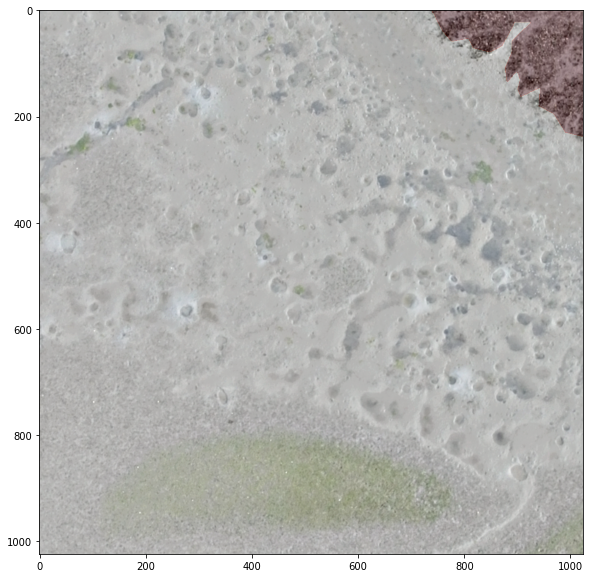

In [0]:
sz = (1024, 1024)

gen = image_batch_generator(train_files, sz, batch_size = 4)

images, masks = next(gen)

plt.figure(figsize=(10,10))
plt.imshow(images[0])
plt.imshow(masks[0].squeeze(), alpha=0.25, cmap=plt.cm.Reds)

In [0]:
!tar -czf train_images.tar.gz /content/1kx1k_dataset/train_images

tar: Removing leading `/' from member names
/content/1kx1k_dataset/train_images/
/content/1kx1k_dataset/train_images/data/
/content/1kx1k_dataset/train_images/data/180522BirdSEO_WGS84_transparent_mosaic_group1---174.png
/content/1kx1k_dataset/train_images/data/180605CarrotEO_transparent_mosaic_group1---240.png
/content/1kx1k_dataset/train_images/data/aug00511.png
/content/1kx1k_dataset/train_images/data/180605CarrotEO_transparent_mosaic_group1---404.png
/content/1kx1k_dataset/train_images/data/180522BirdSEO_WGS84_transparent_mosaic_group1---113.png
/content/1kx1k_dataset/train_images/data/180605CarrotEO_transparent_mosaic_group1---274.png
/content/1kx1k_dataset/train_images/data/180522BirdSEO_WGS84_transparent_mosaic_group1---41.png
/content/1kx1k_dataset/train_images/data/180605CarrotEO_transparent_mosaic_group1---353.png
/content/1kx1k_dataset/train_images/data/180605CarrotEO_transparent_mosaic_group1---331.png
/content/1kx1k_dataset/train_images/data/180605CarrotEO_transparent_mosai

Do the same for the train labels, validation images and validation labels

In [0]:
!tar -czf train_labels.tar.gz /content/1kx1k_dataset/train_labels

tar: Removing leading `/' from member names


In [0]:
!tar -czf val_images.tar.gz /content/1kx1k_dataset/val_images

tar: Removing leading `/' from member names


In [0]:
!tar -czf val_labels.tar.gz /content/1kx1k_dataset/val_labels

tar: Removing leading `/' from member names


finally the test set

In [0]:
!tar -czf test_images.tar.gz /content/1kx1k_dataset/test_images
!tar -czf test_labels.tar.gz /content/1kx1k_dataset/test_labels

tar: Removing leading `/' from member names
tar: Removing leading `/' from member names


For the remainder of the tutorials, we'll be using this version of the data, consisting of imagery and image labels, with an augmented training set consisting of double the original number of imagery, half of which have been augmented with random flips, zoms and rotations

This jupyter notebook running on Google Colab is part of the "Advanced Binary Image Segmentation for the Geo- and Eco-sciences, using Deep Learning" course. The main course website can be accessed [here](https://mardascience.gitlab.io/binary_image_segmentation_for_geosciences/#/)
